In [166]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [167]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [168]:
plt.rcParams['figure.figsize'] = [15, 10]

In [169]:
datatp=pd.read_csv('datasets/Telefonia_movil.csv')
datatp=pd.read_csv('datasets/Telefonia_movil.csv', parse_dates=False)
#datatp.index=datatp.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
#data=data['01-1980':] # filtering the use data from Jan/1980 onwards
#datatp.tail()

In [170]:
datatp.head(3)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
1,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013


In [171]:
def juntar_str(x1, x2):
    x3 = '{}q{}'.format(x1, x2)
    return(x3)

datatp['n_trimestre']=datatp[['Año', 'Trimestre']].apply( lambda x: juntar_str(*x), axis=1)

datatp['n_trimestre'].head(3)

0    2013q1
1    2013q2
2    2013q3
Name: n_trimestre, dtype: object

In [172]:
# bug : https://github.com/pandas-dev/pandas/issues/26109
datatp.loc[datatp.index, 'n_trimestre'] = pd.PeriodIndex(datatp.n_trimestre.values, freq='Q')

In [173]:
datatp.head(2)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo,n_trimestre
0,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013,2013Q1
1,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013,2013Q2


In [174]:
datatp.set_index('n_trimestre', inplace=True)

In [175]:
datatp.head(3)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
n_trimestre,,,,,,
2013Q1,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
2013Q2,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2013Q3,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013


In [176]:
datatp.loc[datatp.index, 'Minutos pospago salientes (miles)'] = datatp.loc[
    datatp.index, 'Minutos pospago salientes (miles)'].str.replace(r'.',r'')

In [177]:
datatp.head(2)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
n_trimestre,,,,,,
2013Q1,2013,1,8785943,6582117,15368060,Ene-Mar 2013
2013Q2,2013,2,9512689,7108640,16621329,Abr-Jun 2013


In [178]:
columnas=['Minutos prepago salientes (miles)', 'Minutos pospago salientes (miles)', ]

In [179]:
for c in columnas:
    datatp[c] = datatp[c].astype(float)

In [180]:
datatp.index

PeriodIndex(['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1'],
            dtype='period[Q-DEC]', name='n_trimestre', freq='Q-DEC')

In [181]:
y1=datatp['Minutos prepago salientes (miles)']
y2=datatp['Minutos pospago salientes (miles)']

## Exploración de los datos

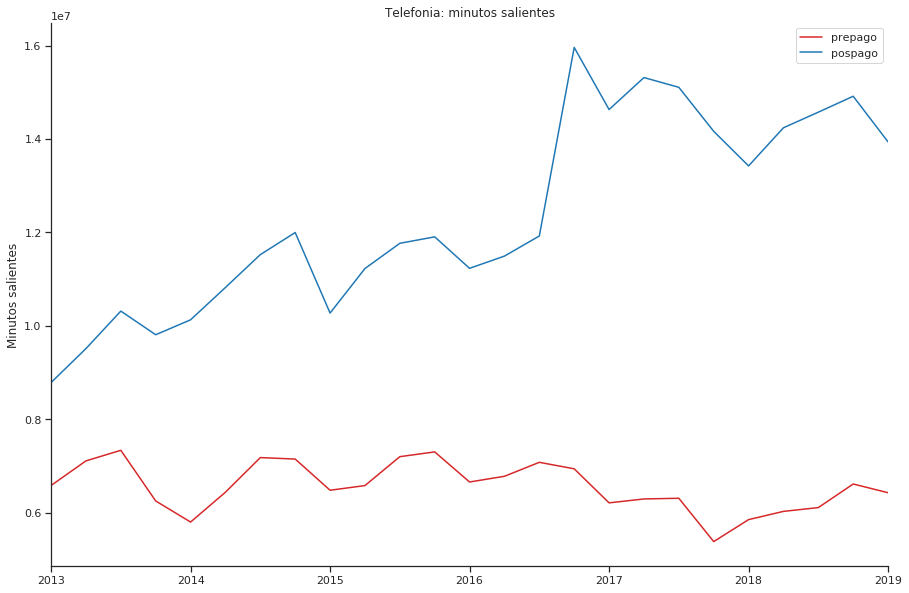

In [182]:
fig, ax= plt.subplots();#figsize=(9,6))

y1.plot(color=red, label='prepago')
y2.plot(color=blue, label='pospago')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Minutos salientes')
ax.set_title('Telefonia: minutos salientes')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

Los minutos prepago se mantienen con poca variación entre 2013-2019. Los minutos pospago aumentaron en 2016 y se mantienen en el nuevo nivel hasta 2019 (al menos lo que se ve con este rango de tiempo)

In [183]:
display(y1.describe().round(2))
display(y2.describe().round(2))

count         25.0
mean     6562909.4
std       516860.4
min      5380710.0
25%      6250549.0
50%      6579819.0
75%      7077838.0
max      7335154.0
Name: Minutos prepago salientes (miles), dtype: float64

count          25.00
mean     12359295.44
std       2085582.33
min       8785943.00
25%      10821463.00
50%      11905073.00
75%      14240217.00
max      15960765.00
Name: Minutos pospago salientes (miles), dtype: float64

## Modelos para predecir en el tiempo

### Random Walk

In [184]:
# serie prepago
h = 4
test=pd.period_range(start=y1.index[-1]+1, periods=h, freq='Q')
pred1=pd.Series(np.repeat(y1.iloc[-1], h), index=test) # RW repite el último valor
display(pred1)

# serie pospago 
h = 4
test=pd.period_range(start=y1.index[-1]+1, periods=h, freq='Q')
pred2=pd.Series(np.repeat(y2.iloc[-1], h), index=test) # RW repite el último valor
display(pred2)

2019Q2    6427084.0
2019Q3    6427084.0
2019Q4    6427084.0
2020Q1    6427084.0
Freq: Q-DEC, dtype: float64

2019Q2    13937271.0
2019Q3    13937271.0
2019Q4    13937271.0
2020Q1    13937271.0
Freq: Q-DEC, dtype: float64

In [185]:
# prepago
resid1=y1-y1.shift(1) # shift desplaza la serie y resta el valor de cada pto al valor anterior (predicción) 
sigma1 = resid1.std()
display(round(sigma1,3))

#pospago
resid2=y2-y2.shift(1) # shift desplaza la serie y resta el valor de cada pto al valor anterior (predicción) 
sigma2 = resid2.std()
display(round(sigma2,3))

510832.977

1111026.926

In [186]:
# prepago
intv1 = pd.concat([pred1-stats.norm.ppf(0.975)*sigma1*np.sqrt(np.arange(1,h+1)),
                   pred1+stats.norm.ppf(0.975)*sigma1*np.sqrt(np.arange(1,h+1))], axis=1)
display(intv1.round(3))

# pospago
intv2 = pd.concat([pred2-stats.norm.ppf(0.975)*sigma2*np.sqrt(np.arange(1,h+1)),
                   pred2+stats.norm.ppf(0.975)*sigma2*np.sqrt(np.arange(1,h+1))], axis=1)
display(intv2.round(3))

,0,1
2019Q2,5425869.763,7428298.237
2019Q3,5011153.247,7843014.753
2019Q4,4692930.072,8161237.928
2020Q1,4424655.526,8429512.474


,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582125e+06,1.829242e+07


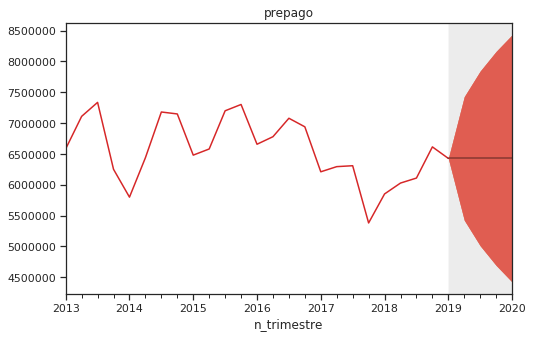

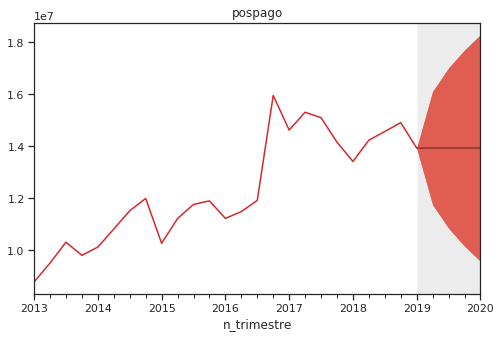

In [187]:
from plotting import fanchart

point_pred1 = (intv1[0]+intv1[1])/2
fig1, ax1 = fanchart(y1,point_pred1,intv1,intv1,intv1)
ax1.set_title("prepago")

point_pred2 = (intv2[0]+intv2[1])/2
fig2, ax2 = fanchart(y2,point_pred2,intv2,intv2,intv2)
ax2.set_title("pospago")
plt.show()

## Otro modelo : simple exponential smoothing

In [188]:
model_ses = sm.tsa.SimpleExpSmoothing(y1).fit()
fitted_ses1 = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,5836570001516.250
Optimized:,True,AIC,658.407
Trend:,None,BIC,660.845
Seasonal:,None,AICC,660.407
Seasonal Periods:,None,Date:,"Tue, 10 Sep 2019"
Box-Cox:,False,Time:,16:23:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4341128,alpha,True
initial_level,6.6993e+06,l.0,True


In [189]:
mse_ses1 = sm.tools.eval_measures.mse(y1,fitted_ses1)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses1))

 In-sample fit:
 MSE               233462800060.650


In [190]:
model_ses = sm.tsa.SimpleExpSmoothing(y2).fit()
fitted_ses2 = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,28393933896676.352
Optimized:,True,AIC,697.958
Trend:,None,BIC,700.396
Seasonal:,None,AICC,699.958
Seasonal Periods:,None,Date:,"Tue, 10 Sep 2019"
Box-Cox:,False,Time:,16:23:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7870587,alpha,True
initial_level,8.7859e+06,l.0,True


In [191]:
mse_ses2 = sm.tools.eval_measures.mse(y2,fitted_ses2)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses2))

 In-sample fit:
 MSE               1135757355867.054


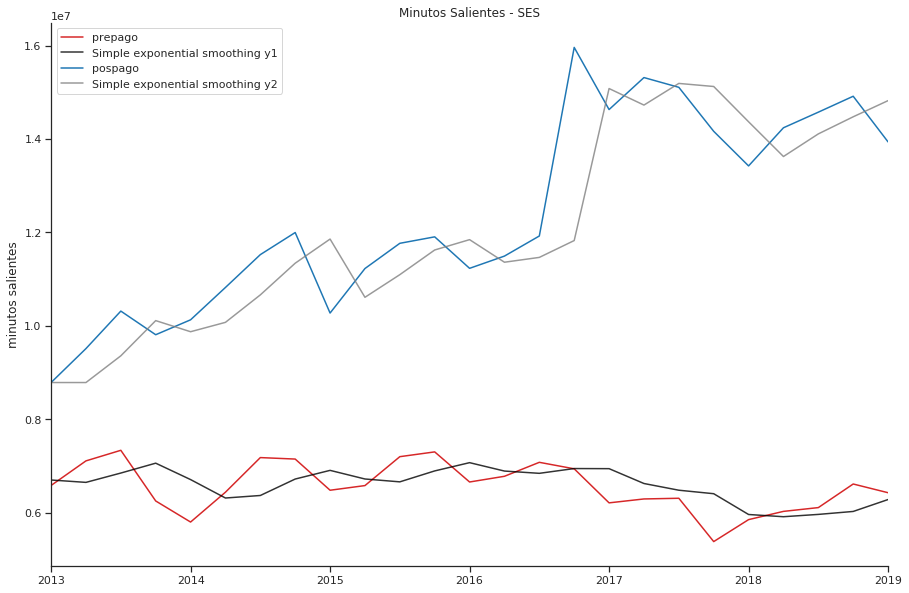

In [192]:
fig, ax= plt.subplots();#figsize=(9,6))
y1.plot(color=red, label='prepago')
fitted_ses1.plot(color='black', label='Simple exponential smoothing y1', alpha=0.8)
y2.plot(color=blue, label='pospago')
fitted_ses2.plot(color='gray', label='Simple exponential smoothing y2', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('minutos salientes')
ax.set_title('Minutos Salientes - SES')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Diagnóstico del modelo

## RW

In [193]:
resid1=resid1[1:]
resid2=resid2[1:]

In [194]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return (fig, ax)

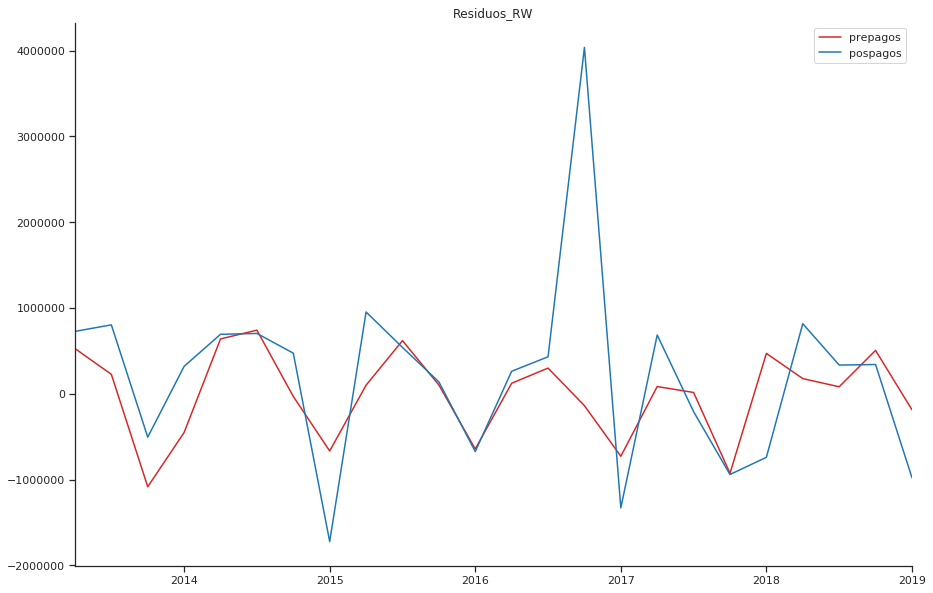

In [195]:
fig, ax= plt.subplots();#figsize=(9,6))
resid1.plot(color=red, label='prepagos')
resid2.plot(color=blue, label='pospagos')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residuos_RW')
ax.legend()
sns.despine()
plt.show()

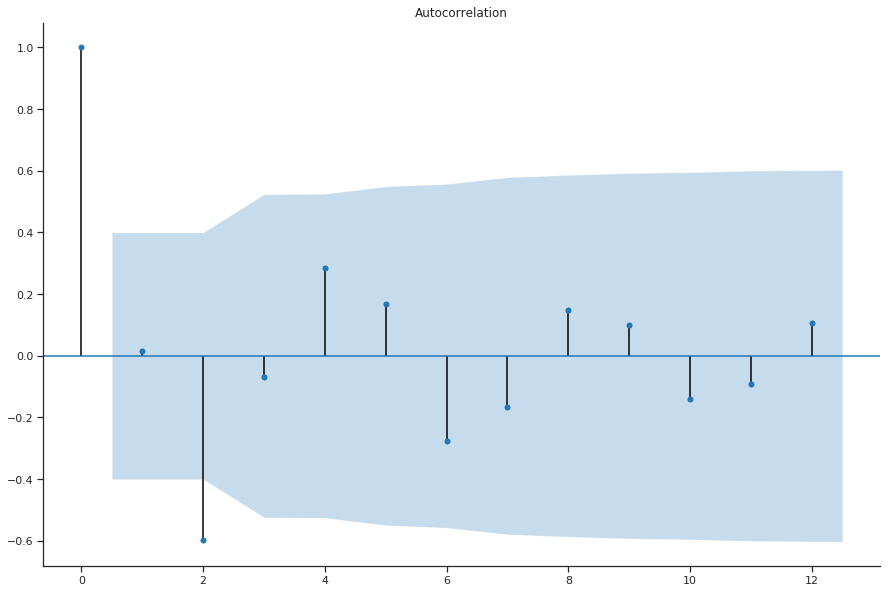

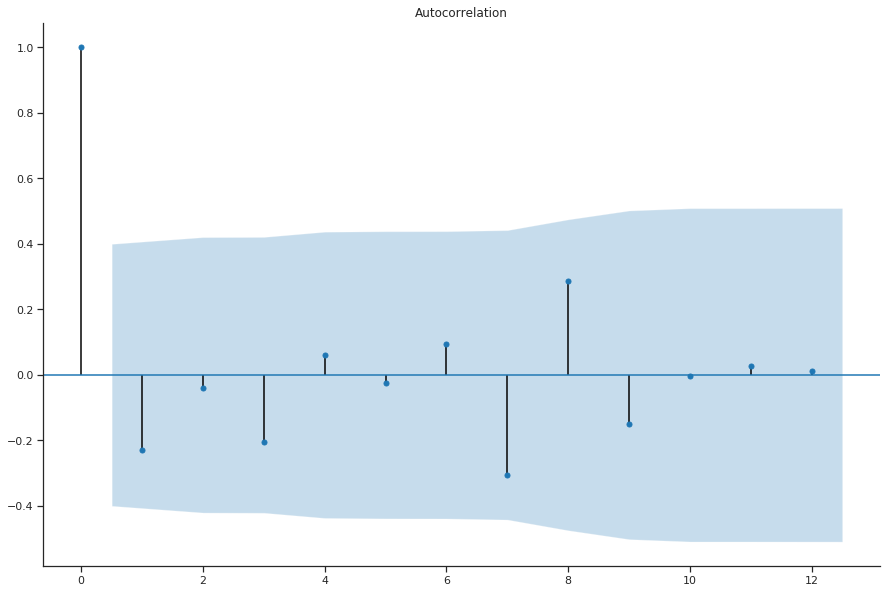

In [196]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid1, lags=12, ax=ax)
sns.despine()
plt.show()
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid2, lags=12, ax=ax)
sns.despine()
plt.show()

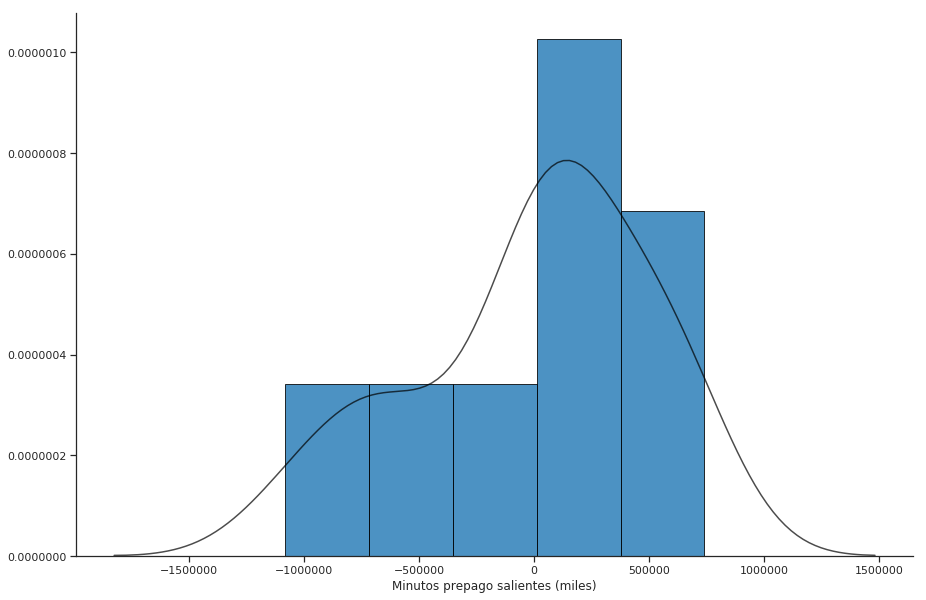

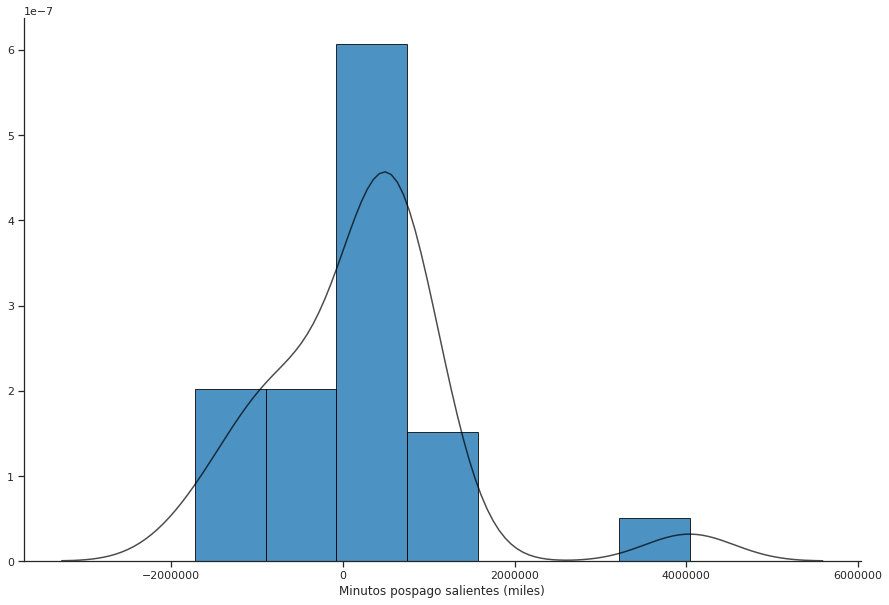

In [197]:
hist(resid1)
plt.show()
hist(resid2)
plt.show()

Los residuos parecen bastante descorrelacionados. Se ve una correlación negativa un poco mayor en valor absoluto (0.4), en n=2 para prepago. En los datos originales se notan algunos períodos anuales seguidos que deben ser el motivo de ese valor un poco mayor. Los residuos no son gausianos. El residuo grande en "pospago" es porque el modelo no reproduce el salto abrupto (año=2016), que se ve en los datos originales.  

## SES

In [198]:
resid_ses1=y1-fitted_ses1
resid_ses2=y2-fitted_ses2

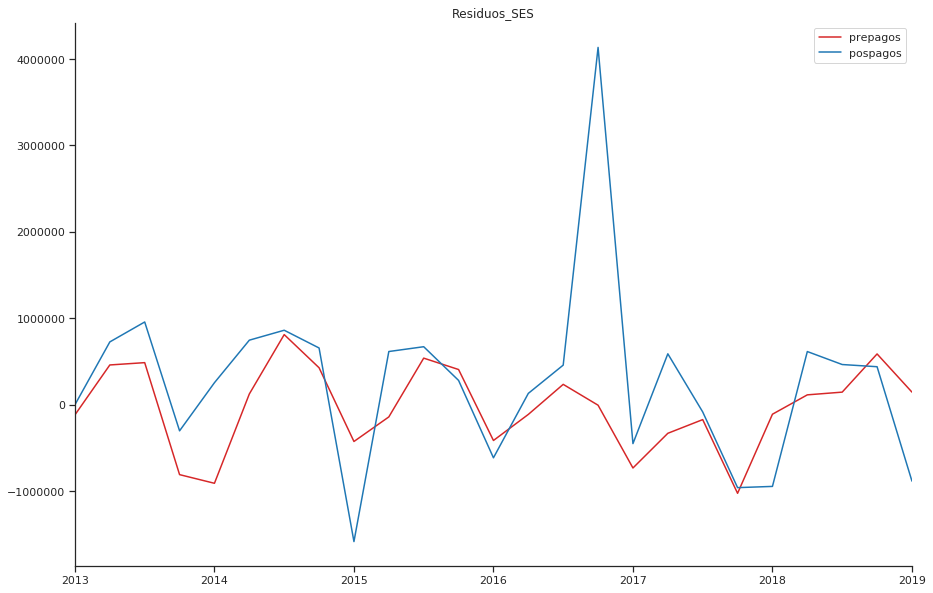

In [199]:
fig, ax= plt.subplots();#figsize=(9,6))
resid_ses1.plot(color=red, label='prepagos')
resid_ses2.plot(color=blue, label='pospagos')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residuos_SES')
ax.legend()
sns.despine()
plt.show()

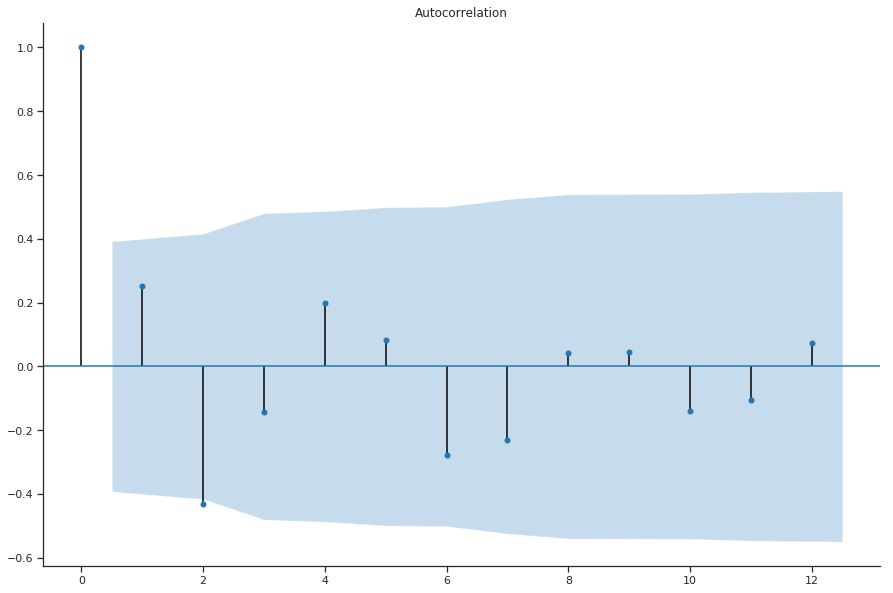

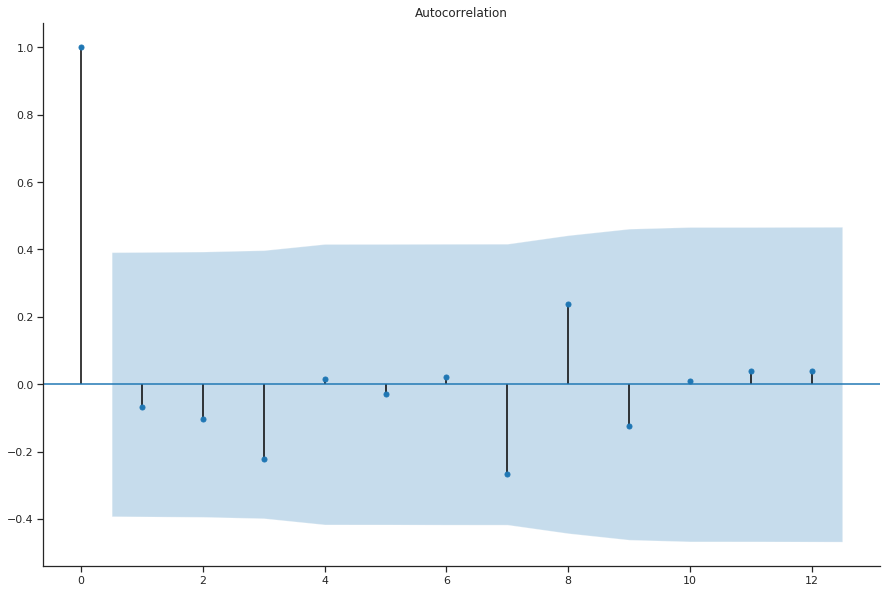

In [200]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid_ses1, lags=12, ax=ax)
sns.despine()
plt.show()
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid_ses2, lags=12, ax=ax)
sns.despine()
plt.show()

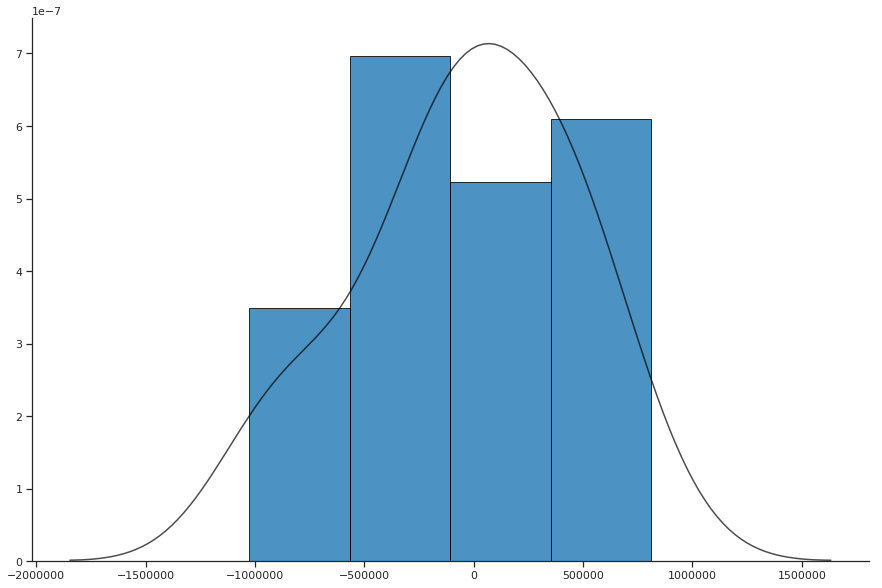

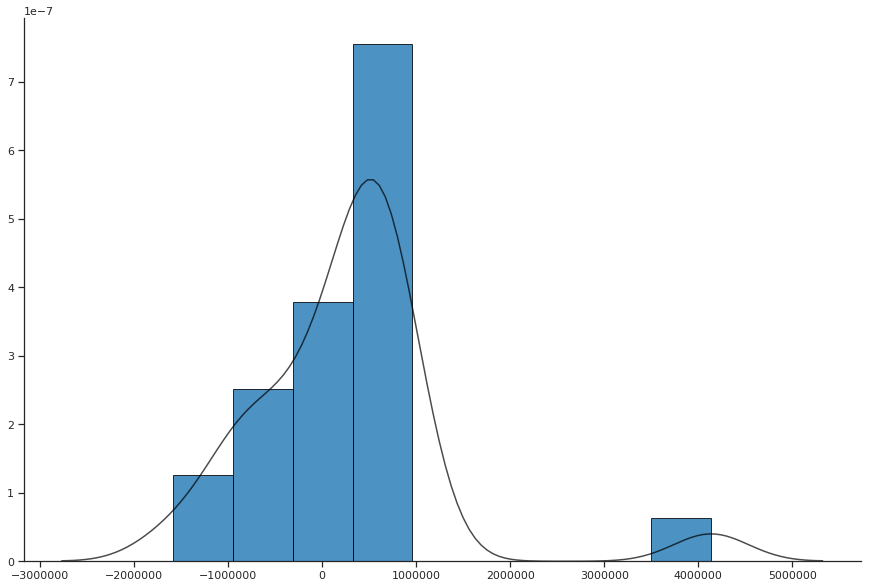

In [201]:
hist(resid_ses1)
plt.show()
hist(resid_ses2)
plt.show()

Muy similar a lo que se ve con random walk

## VALIDACION

In [218]:
#prepago
validation=y1['2016Q3':].index # validación desde 2016 Q3 (40% de los datos)
start = y1.index.get_loc('2016Q3') # indice de 2017 Q1

pred1_1 = []
pred2_1 = []
actual_1= []
for i in range(start, len(y1)):
    
    actual_1.append(y1.iloc[i]) # actual value
    
    pred1_1.append(y1.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y1.iloc[:i]).fit() 
    pred2_1.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm_1 = np.vstack([pred1_1,pred2_1,actual_1]).T
results_sm_1 = pd.DataFrame(results_sm_1, columns=columns, index=validation)

/home/carla/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/carla/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/carla/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [219]:
#pospago
validation=y2['2016Q3':].index # validación desde 2016 Q3 (40% de los datos)
start = y2.index.get_loc('2016Q3') # indice de 2017 Q1

pred1_2 = []
pred2_2 = []
actual_2= []
for i in range(start, len(y2)):
    
    actual_2.append(y2.iloc[i]) # actual value
    
    pred1_2.append(y2.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y2.iloc[:i]).fit() 
    pred2_2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm_2 = np.vstack([pred1_2,pred2_2,actual_2]).T
results_sm_2 = pd.DataFrame(results_sm_2, columns=columns, index=validation)

In [220]:
print("prepago")
display(results_sm_1.tail())
print("pospago")
display(results_sm_2.tail())

prepago


,RW,SES,Actual
n_trimestre,,,
2018Q1,5380710.0,6.652112e+06,5850985.0
2018Q2,5850985.0,5.888787e+06,6027374.0
2018Q3,6027374.0,5.961229e+06,6108477.0
2018Q4,6108477.0,6.026748e+06,6613685.0
2019Q1,6613685.0,6.265480e+06,6427084.0


pospago


,RW,SES,Actual
n_trimestre,,,
2018Q1,14164552.0,1.437147e+07,13423580.0
2018Q2,13423580.0,1.359029e+07,14240217.0
2018Q3,14240217.0,1.411031e+07,14574305.0
2018Q4,14574305.0,1.448080e+07,14915060.0
2019Q1,14915060.0,1.482888e+07,13937271.0


In [221]:
from scipy import stats

table_1 = pd.DataFrame(0.0, index=results_sm_1.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table_1.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm_1.iloc[:,i], results_sm_1.iloc[:,-1])
    table_1.iloc[i,1] = (results_sm_1.iloc[:,i] - results_sm_1.iloc[:,-1]).sem()
    
table_2 = pd.DataFrame(0.0, index=results_sm_2.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table_2.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm_2.iloc[:,i], results_sm_2.iloc[:,-1])
    table_2.iloc[i,1] = (results_sm_2.iloc[:,i] - results_sm_2.iloc[:,-1]).sem()

print("prepago")
display(table_1.round(3))
print("pospago")
display(table_2.round(3))

prepago


,RMSE,SE
RW,432408.343,136365.326
SES,581764.372,173209.159


pospago


,RMSE,SE
RW,1415984.095,442225.773
SES,1451825.917,453162.579


En el caso de datos de prepago RW predice mejor que SES. Para los datos pospago, ambos modelos dan prácticamente lo mismo, y los errores son mucho mayores que para los datos de prepago.